# Show some basics and options for the retrieval
This notebooks reads a sample spectra and illustrates the retrieval from Barret et al. (2019) and some sensitivities for the particle properties

In [1]:
from PSDretrieval import processRadar as pR
from PSDretrieval import plotting as pl
from PSDretrieval import scattering as sc
from PSDretrieval import retrievalUtils as rU
import snowScatt
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#define time
date = "20190113"
time = "06:18:04"
hcenter=1600 #[m]

SpecWindow = pR.loadSpectra(loadSample=False,dataPath="/data/obs/campaigns/tripex-pol/processed/",createSample=True,date=date,time=time,tRange=1,hRange=180,hcenter=hcenter)
SpecSingle  = pR.selectSingleTimeHeight(SpecWindow)

load file:/data/obs/campaigns/tripex-pol/processed/
interp X done
interp Ka done
interp W done
merging datasets done
X offsets added


In [14]:
SpecSingle

<xarray.Dataset>
Dimensions:   (doppler: 400)
Coordinates:
    time      datetime64[ns] 2019-01-13T06:18:04
    range     float64 1.584e+03
  * doppler   (doppler) float64 -3.0 -2.99 -2.98 -2.97 ... 0.96 0.97 0.98 0.99
Data variables:
    WSpecH    (doppler) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    KaSpecH   (doppler) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    XSpecH    (doppler) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    DWR_X_Ka  (doppler) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    DWR_Ka_W  (doppler) float64 dask.array<chunksize=(1,), meta=np.ndarray>

### plot the sample spectrum

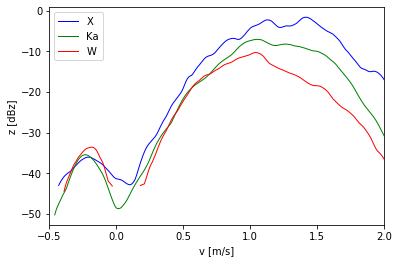

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotObsSpectra(SpecSingle,ax)

## 1. Calculate spectral DWR

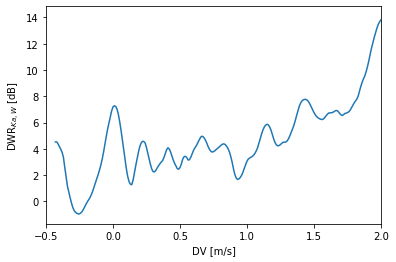

In [16]:
DWRkey="DWR_X_Ka"
fig,ax = plt.subplots(nrows=1,ncols=1)
ax = pl.plotSpectralDWR(SpecSingle[DWRkey],ax)

## 2. Get Dmax from sDWR taking predefined scattering properties from snowScatt
### 2.1 get unambiguous DWR-Dmax

In [17]:
#snowScatt.snowLibrary.info() #use this line to show available particle types


DmaxRetr 10.0 DmaxAtDWRmax 9.797448724362182 DWRmin 13.528055501049902


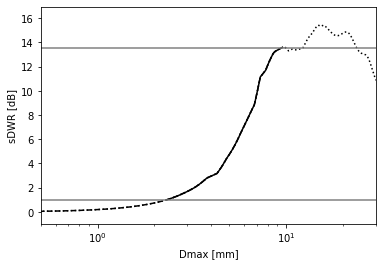

In [7]:
particleType = "vonTerzi_mixcoldend" #select a particle type

DWRxk,DWRkw,Dmax = sc.getDWRs(particleType,Dmax=np.linspace(0.3e-3, 50.0e-3, 2000),Kfreq="Ka") #get DWR(Dmax) relations from snowScatt
if DWRkey=="DWR_Ka_W":
    DWR = DWRkw
    DmaxRetr = 5e-3 #[m] maximum size considered in retrieval; this inexplicitly assumes that larger particles are not relevant
elif DWRkey=="DWR_X_Ka":
    DWR = DWRxk
    DmaxRetr = 1e-2 #[m] maximum size considered in retrieval; this inexplicitly assumes that larger particles are not relevant

DWRlowDetect = 1 #[dB] DWRs smaller than this are disregarded (detection limit)

fig,ax = plt.subplots(nrows=1,ncols=1)
DWRUnamb,ax = sc.getUnambigousDWRdmax(Dmax,DWR,DmaxRetr=DmaxRetr,DWRlowDetect=DWRlowDetect,showIllus=True,ax=ax) #get Unambiguous DWR-Dmax relation

## 3. get Dmax from sDWR at each velocity bin

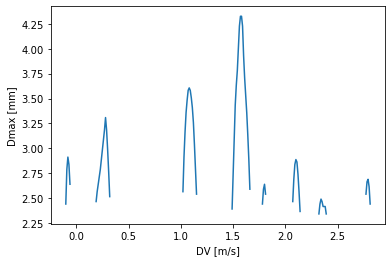

In [8]:
DmaxfromDWR = rU.getDmaxFromSDWR(SpecSingle[DWRkey],DWRUnamb,Dmax,showIllus=True,ax=None)

## 4. get mass from Dmax and the selected particle type

In [9]:
#get array of masses from the database #TODO: this is not really necessary because snowScatt selects the consistent m(D) anyway in "sc.model3fOne"
mass, __, __ = snowScatt.snowMassVelocityArea(DmaxfromDWR, particleType)

Text(0, 0.5, 'm [kg]')

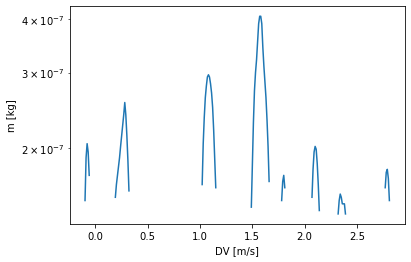

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.semilogy(-SpecSingle[DWRkey].doppler,mass)
ax.set_xlabel("DV [m/s]")
ax.set_ylabel("m [kg]")

## 5. get the single particle reflectivity

In [11]:
ZkOne = sc.getSinglePartRefl(particleType,DmaxfromDWR,freq="k")

## 6. divide the observed z (power at a specific DV) by Zone to get the number concentration N

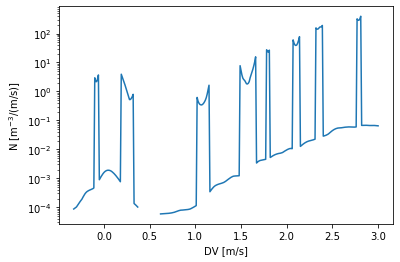

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1)
Nnorm,ax = rU.calcNumberConcFromSpectrumAndZOne(SpecSingle.KaSpecH,ZkOne,showIllus=True,ax=ax)